## Find out impact of various factors on CO2 emission using Panel Regression

### Introduction to Panel Regression

Panel data are repeated observations from time period t = 1, …, n for the same entity (country in our case).

Panel regression model is a statistical model for panel data which allows elimination of bias from (i) factors that differ across entities but are constant over time (fixed effect); and (ii) factors that change over time but are constant over entities (time effect) when estimating the regression coefficients. 

Model specification (assuming there are p independent variables, n time points, m entities):

$Y_{it}$ = $β_{0}$ + $β_{1}$$X_{1it}$ + $β_{2}$$X_{2it}$ +...+ $β_{p}$$X_{pit}$ + Entity Fixed Effects + Time Fixed Effects + $u_{it}$

where 

$Y_{it}$ is the response / dependent variable of entity i at time t, i = 1,...,m; t = 1,...,n (carbon dioxide emission in our case);

$X_{pit}$ is the pth independent variable of entity i at time t;

Time Fixed Effects = $γ_{1}$$T_{1}$ + $γ_{2}$$T_{2}$ +...+ $γ_{n}$$T_{n}$; $T_{1}$,..., $T_{n}$ are dummy variables, where $T_{1}$ = 1 if t = 1 and 0 otherwise.  Similarly for other $T_{t}$ from t = 2 to n.

Entity Fixed Effects = $δ_{1}$$E_{1}$ + $δ_{2}$$E_{2}$ +...+ $δ_{m}$$E_{m}$; $E_{1}$,..., $E_{m}$ are dummy variables, where $E_{1}$ = 1 if i = 1 and 0 otherwise.  Similarly for other $E_{i}$ from i = 2 to m.

$u_{it}$ is random error which follows standard normal distribution


In [1]:
# Import libraries
from library.common import Database
import pathlib

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# import seaborn as sns 
import altair as alt
import warnings
warnings.filterwarnings("ignore")
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects

# Display all columns of pandas dataframes
pd.set_option('display.max_columns', None)

db = Database()
write_to_db = True

# Get the path to raw data files
# path = pathlib.Path.cwd().parent.joinpath(path_to_data)

### Preparing the dataset

Read the consolidated_data from Database

In [2]:
data2 = pd.read_sql('master_dataset', db.config)
data2

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp,population,current_gdp,constant_gdp,manufacturing_gdp,medium_to_high_tech_percent,export,import,real_gdp_growth_percent,urban_population_percent,merchandise_export,merchandise_import,manufacturer_export_share,manufacturer_export,co2_emission_electricity,co2_emission_building,co2_emission_manufacturing,co2_emission_other_fuel,co2_emission_fugitive,co2_emission_transport,co2_emission_energy_subtotal,co2_emission_bunkers,co2_emission_industrial_process,co2_emission_per_capita,constant_gdp_per_capita,manufacturing_percent,medium_to_high_tech_gdp,co2_emission_per_constant_gdp,trade_openness,share_of_merchandise_export,share_of_merchandise_import,industrial_gdp,co2_country_share_percent,manufacturing_country_share_percent,iea_primary_energy_consumption,renewable_energy_consumption,coal_consumption,oil_consumption,total_electricity_production,electricity_production_from_renewable,primary_energy_consumption_per_capita,fossil_energy_consumption_share,renewable_electricity_production_share,energy_intensity,renewable_energy_consumption_share,percent_of_environment_patent,region,income_group
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,NaN,0.015,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,AFG,Afghanistan,1950,0.084,NaN,475.0,0.070,NaN,0.011,NaN,NaN,0.099,NaN,0.009,NaN,NaN,0.021,NaN,NaN,NaN,0.063,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036,NaN,NaN,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.421400e+09,NaN,NaN,NaN,7752117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,AFG,Afghanistan,1951,0.092,NaN,8.7,0.007,NaN,0.012,NaN,NaN,0.191,NaN,0.010,NaN,NaN,0.026,NaN,NaN,NaN,0.066,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.692280e+09,NaN,NaN,NaN,7840151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,AFG,Afghanistan,1952,0.092,NaN,NaN,NaN,NaN,0.012,NaN,NaN,0.282,NaN,0.009,NaN,NaN,0.032,NaN,NaN,NaN,0.060,NaN,NaN,0.004,NaN,NaN,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,0.189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.001732e+10,NaN,NaN,NaN,7935996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No

In [3]:
col_use = ['year','iso_code','region','income_group','co2','co2_emission_per_capita','co2_emission_per_constant_gdp',
           'population','urban_population_percent','constant_gdp_per_capita','manufacturing_percent','manufacturing_country_share_percent',
           'trade_openness','primary_energy_consumption_per_capita','renewable_energy_consumption_share','percent_of_environment_patent','energy_intensity',
          ]
data2=data2[col_use]

In [4]:
diff_lst=['MTQ','GUF','MSR','COK','BES','ATA','SHN','TWN','SPM','MYT','AIA','CXR','GLP','NIU']
data2=data2[data2['year']>=1960]
data2_world=data2[data2['iso_code']=='WLD']
data2=data2[data2['iso_code']!='WLD']
data2=data2[~data2['iso_code'].isin(diff_lst)]
data2=data2.sort_values(["year", "iso_code"], ascending = (True, True))
data2=data2.append(data2_world).reset_index()
data2.drop(['index'],axis=1,inplace=True)
data2['co2']=data2['co2']*1000
data2['constant_gdp']=data2['constant_gdp_per_capita']*data2['population']
data2['primary_energy_consumption']=data2['primary_energy_consumption_per_capita']*data2['population']
data2['renewable_energy_consumption_per_capita']=(data2['primary_energy_consumption']*0.000000041868*(data2['renewable_energy_consumption_share']/100))/data2['population']
data2

,year,iso_code,region,income_group,co2,co2_emission_per_capita,co2_emission_per_constant_gdp,population,urban_population_percent,constant_gdp_per_capita,manufacturing_percent,manufacturing_country_share_percent,trade_openness,primary_energy_consumption_per_capita,renewable_energy_consumption_share,percent_of_environment_patent,energy_intensity,constant_gdp,primary_energy_consumption,renewable_energy_consumption_per_capita
0,1960,ABW,Latin America & Caribbean,High income,619.0,11.418979,NaN,5.420800e+04,50.776000,NaN,1.622890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960,AFG,South Asia,Low income,414.0,0.046016,NaN,8.996967e+06,8.401000,NaN,57.870432,0.111997,11.157027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,AGO,Sub-Saharan Africa,Lower middle income,549.0,0.100643,NaN,5.454938e+06,10.435000,NaN,9.174312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960,ALB,Europe & Central Asia,Upper middle income,2023.0,1.257459,NaN,1.608800e+06,30.705000,NaN,17.419305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,AND,Europe & Central Asia,High income,NaN,NaN,NaN,1.341000e+04,58.450000,NaN,3.658603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13293,2016,WLD,None,None,35452459.0,4.775073,0.460422,7.424485e+09,54.370833,10371.090074,15.871077,100.000000,52.966660,1842.786095,13.525051,11.35,0.177685,7.700000e+13,1.368174e+13,0.000010
13294,2017,WLD,None,None,35925738.0,4.784096,0.451328,7.509410e+09,54.823831,10600.033502,15.922419,100.000000,54.805629,1860.787862,13.703840,11.03,0.175545,7.960000e+13,1.397342e+13,0.000011
13295,2018,WLD,None,None,36646140.0,4.826639,0.446360,7.592476e+09,55.271710,10813.337331,15.978074,100.000000,56.685777,1886.495527,13.843189,10.26,0.174460,8.210000e+13,1.432317e+13,0.000011
13296,2019,WLD,None,None,36702503.0,4.783116,0.436415,7.673345e+09,55.714433,10960.017530,15.748604,100.000000,54.824262,1887.801706,14.085170,NaN,0.172244,8.410000e+13,1.448575e+13,0.000011


In [5]:
# Clusters using machine learning algorithm 
country_gp0=['AFG', 'ALB', 'AND', 'AGO', 'ATG', 'ARM', 'ABW', 'BHS', 'BHR', 'BRB', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 
             'BWA', 'VGB', 'BRN', 'BFA', 'BDI', 'KHM', 'CMR', 'CPV', 'CAF', 'TCD', 'COM', 'COG', 'CRI', 'CIV', 'CUB', 'CUW', 
             'COD', 'DJI', 'DMA', 'DOM', 'SLV', 'GNQ', 'ERI', 'SWZ', 'ETH', 'FRO', 'FJI', 'PYF', 'GAB', 'GMB', 'GEO', 'GHA', 
             'GRL', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'ISL', 'ATA', 'JAM', 'JOR', 'KEN', 'KIR', 'KGZ', 'LAO', 
             'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'MDG', 'MWI', 'MDV', 'MLI', 'MLT', 'MHL', 'MRT', 'MUS', 'MDA', 'MNG', 'MNE', 
             'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'CXR', 'NCL', 'NIC', 'NER', 'NGA', 'PRK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 
             'PRI', 'RWA', 'KNA', 'LCA', 'VCT', 'WSM', 'STP', 'SEN', 'SRB', 'SYC', 'SLE', 'SXM', 'SLB', 'SOM', 'SSD', 'LKA', 
             'SDN', 'SUR', 'SYR', 'TJK', 'TZA', 'TLS', 'TGO', 'TON', 'TUN', 'TCA', 'TUV', 'UGA', 'URY', 'VUT', 'YEM', 'ZMB', 
             'ZWE', 'AIA', 'BES', 'COK', 'GUF', 'GLP', 'MTQ', 'MYT', 'MSR', 'NIU', 'SHN', 'SPM', 'TWN', 'ASM', 'CHI', 'CYM', 
             'FSM', 'GIB', 'GUM', 'IMN', 'MAC', 'MAF', 'MCO', 'MNP', 'SMR', 'VIR', 'XKX'] # Cluster 0
country_gp1=['CHN','USA'] # Cluster 1
country_gp2=['DZA', 'ARG', 'AUS', 'AUT', 'AZE', 'BGD', 'BLR', 'BEL', 'BRA', 'BGR', 'CAN', 'CHL', 'COL', 'HRV', 'CYP', 'CZE', 
             'DNK', 'ECU', 'EGY', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HKG', 'HUN', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'ISR', 
             'ITA', 'JPN', 'KAZ', 'KWT', 'LVA', 'LTU', 'LUX', 'MYS', 'MEX', 'MAR', 'NLD', 'NZL', 'MKD', 'NOR', 'OMN', 'PAK', 
             'PER', 'PHL', 'POL', 'PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SGP', 'SVK', 'SVN', 'ZAF', 'KOR', 'ESP', 'SWE', 'CHE', 
             'THA', 'TTO', 'TUR', 'TKM', 'UKR', 'ARE', 'GBR', 'UZB', 'VEN', 'VNM'] # Cluster 2

In panel regression model, number of time points of all features within an entity must be the same. If every entity has the same number of time points for each feature, it is a balanced panel data.  Otherwise, it is an unbalanced panel data.  We have unbalanced panel data in our case.

Since some of the features like energy consumption in our datasets only start from 1971 (or even later) for some countries, we use observations from 1971. We do not further trim observations (say using data from 2000) because there will not be enough observations for cluster 1, which comprises only China and the US. To cater for heteroskedascity issue frequently observed in time series, natural log has been taken for each feature in the model so that the residuals will more likely have homogeneous variance.

In [6]:
# Subset observations from 1971 for model fitting because we do not have 1960-1970 energy consumption data
analysis_df=data2[(data2['year']>=1971)&(data2['iso_code']!='WLD')]
analysis_df['country_gp0']=np.where(analysis_df['iso_code'].isin(country_gp0),1,0)
analysis_df['country_gp1']=np.where(analysis_df['iso_code'].isin(country_gp1),1,0)
analysis_df['country_gp2']=np.where(analysis_df['iso_code'].isin(country_gp2),1,0)

# Take log on independent and dependent variables
analysis_df['log_total_co2']=np.log(analysis_df['co2'])
analysis_df['log_co2_per_capita']=np.log(analysis_df['co2_emission_per_capita'])
analysis_df['log_co2_intensity']=np.log(analysis_df['co2_emission_per_constant_gdp'])
analysis_df['log_population']=np.log(analysis_df['population'])
analysis_df['log_urban_percent']=np.log(analysis_df['urban_population_percent'])
analysis_df['log_gdp_per_capita']=np.log(analysis_df['constant_gdp_per_capita'])
analysis_df['log_gdp_per_capita_sq']=np.log(analysis_df['constant_gdp_per_capita'])*np.log(analysis_df['constant_gdp_per_capita'])
analysis_df['log_manufacturing_share']=np.log(analysis_df['manufacturing_percent'])
#analysis_df['log_global_manufacturing_share']=np.log(analysis_df['manufacturing_country_share_percent'])
analysis_df['log_trade']=np.log(analysis_df['trade_openness'])
analysis_df['log_energy_intensity']=np.log(analysis_df['energy_intensity'])
analysis_df['log_renewable_share']=np.log(analysis_df['renewable_energy_consumption_share'])
analysis_df['log_renewable_share_sq']=np.log(analysis_df['renewable_energy_consumption_share'])*np.log(analysis_df['renewable_energy_consumption_share'])
#analysis_df['log_renewable_energy_consumption_per_capita']=np.log(analysis_df['renewable_energy_consumption_per_capita'])
analysis_df['log_patent_percent']=np.log(analysis_df['percent_of_environment_patent'])

In [7]:
# Subset dataframe
analysis_2000_df=analysis_df[(analysis_df['year']>=1971)&(analysis_df['year']<=2020)&(analysis_df['iso_code']!='WLD')]
analysis_2000_df2 = analysis_2000_df.copy(deep=True)
analysis_2000_df = analysis_2000_df.dropna(subset=['log_population','log_urban_percent','log_gdp_per_capita','log_gdp_per_capita_sq','log_energy_intensity',
                                                   'log_manufacturing_share','log_trade','log_renewable_share','log_renewable_share_sq',
#                                                  'log_patent_percent',
                                                  ])

# Break up dataframe into three clusters
analysis_2000_df_cluster0 = analysis_2000_df[analysis_2000_df['country_gp0']==1]
analysis_2000_df_cluster1 = analysis_2000_df[analysis_2000_df['country_gp1']==1]
analysis_2000_df_cluster2 = analysis_2000_df[analysis_2000_df['country_gp2']==1]
analysis_2000_df_cluster12 = analysis_2000_df[(analysis_2000_df['country_gp1']==1)|(analysis_2000_df['country_gp2']==1)]

# Create a dataframe copy
analysis_2000_df2_cluster0 = analysis_2000_df_cluster0.copy(deep=True)
analysis_2000_df2_cluster1 = analysis_2000_df_cluster1.copy(deep=True)
analysis_2000_df2_cluster2 = analysis_2000_df_cluster2.copy(deep=True)
analysis_2000_df2_cluster12 = analysis_2000_df_cluster12.copy(deep=True)

# Prepare the dataframe (all clusters) for panel regression
analysis_2000_df=analysis_2000_df.set_index(['iso_code','year'])

years = analysis_2000_df.index.get_level_values('year').to_list()
analysis_2000_df['year'] = pd.Categorical(years)

# Prepare the dataframe (cluster 0) for panel regression
analysis_2000_df_cluster0=analysis_2000_df_cluster0.set_index(['iso_code','year'])

years = analysis_2000_df_cluster0.index.get_level_values('year').to_list()
analysis_2000_df_cluster0['year'] = pd.Categorical(years)

# Prepare the dataframe (cluster 1) for panel regression
analysis_2000_df_cluster1=analysis_2000_df_cluster1.set_index(['iso_code','year'])

years = analysis_2000_df_cluster1.index.get_level_values('year').to_list()
analysis_2000_df_cluster1['year'] = pd.Categorical(years)

# Prepare the dataframe (cluster 2) for panel regression
analysis_2000_df_cluster2=analysis_2000_df_cluster2.set_index(['iso_code','year'])

years = analysis_2000_df_cluster2.index.get_level_values('year').to_list()
analysis_2000_df_cluster2['year'] = pd.Categorical(years)

# Prepare the dataframe (clusters 1&2) for panel regression
analysis_2000_df_cluster12=analysis_2000_df_cluster12.set_index(['iso_code','year'])

years = analysis_2000_df_cluster12.index.get_level_values('year').to_list()
analysis_2000_df_cluster12['year'] = pd.Categorical(years)

analysis_2000_df

,,region,income_group,co2,co2_emission_per_capita,co2_emission_per_constant_gdp,population,urban_population_percent,constant_gdp_per_capita,manufacturing_percent,manufacturing_country_share_percent,trade_openness,primary_energy_consumption_per_capita,renewable_energy_consumption_share,percent_of_environment_patent,energy_intensity,constant_gdp,primary_energy_consumption,renewable_energy_consumption_per_capita,country_gp0,country_gp1,country_gp2,log_total_co2,log_co2_per_capita,log_co2_intensity,log_population,log_urban_percent,log_gdp_per_capita,log_gdp_per_capita_sq,log_manufacturing_share,log_trade,log_energy_intensity,log_renewable_share,log_renewable_share_sq,log_patent_percent,year
iso_code,year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AUS,1971,East Asia & Pacific,High income,152630.0,11.797944,0.466758,12937000.0,84.160,25276.339182,20.586231,1.092694,22.926896,3989.708363,8.823028,18.00,0.157844,3.270000e+11,5.161486e+10,1.473808e-05,0,0,1,11.935772,2.467925,-0.761943,16.375602,4.432720,10.137624,102.771421,3.024622,3.132311,-1.846151,2.177365,4.740919,2.890372,1971
AUT,1971,Europe & Central Asia,High income,52069.0,6.942087,0.366683,7500482.0,65.301,18932.116629,28.498786,0.536036,54.379668,2508.618139,10.988093,5.88,0.132506,1.420000e+11,1.881585e+10,1.154088e-05,0,0,1,10.860325,1.937602,-1.003257,15.830478,4.179007,9.848615,96.995218,3.349861,3.995990,-2.021128,2.396812,5.744709,1.771557,1971
BEL,1971,Europe & Central Asia,High income,121371.0,12.547190,0.678050,9673162.0,93.976,18504.807425,28.256268,0.887496,85.583428,4100.094973,0.029051,8.28,0.221569,1.790000e+11,3.966088e+10,4.986983e-08,0,0,1,11.706607,2.529497,-0.388534,16.084866,4.543039,9.825786,96.546067,3.341315,4.449492,-1.507020,-3.538701,12.522404,2.113843,1971
CAN,1971,North America,High income,352287.0,16.040729,0.740099,21962032.0,76.090,21673.768620,20.079589,2.135958,40.125581,6436.576798,15.276061,6.83,0.296975,4.760000e+11,1.413603e+11,4.116694e-05,0,0,1,12.772201,2.775131,-0.300972,16.904826,4.331917,9.983858,99.677420,2.999704,3.692014,-1.214106,2.726287,7.432641,1.921325,1971
CHE,1971,Europe & Central Asia,High income,41888.0,6.741560,0.120368,6213399.0,73.992,56007.991761,23.132112,0.710682,80.863074,2637.607435,15.509637,4.52,0.047093,3.480000e+11,1.638851e+10,1.712750e-05,0,0,1,10.642755,1.908291,-2.117203,15.642219,4.303957,10.933250,119.535948,3.141222,4.392757,-3.055622,2.741462,7.515612,1.508512,1971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URY,2020,Latin America & Caribbean,High income,5840.0,1.681191,0.111747,3473727.0,95.515,15044.640031,10.296801,0.042263,46.368308,1252.586103,60.729099,NaN,0.083258,5.226097e+10,4.351142e+09,3.184833e-05,1,0,0,8.672486,0.519503,-2.191519,15.060739,4.559283,9.618777,92.520872,2.331833,3.836616,-2.485811,4.106423,16.862710,NaN,2020
USA,2020,North America,High income,4712771.0,14.303484,0.244461,329484123.0,82.664,58510.254833,10.851810,17.388810,23.394486,6173.838659,8.718734,NaN,0.105517,1.927820e+13,2.034182e+12,2.253673e-05,0,1,0,15.365787,2.660503,-1.408699,19.613039,4.414784,10.976957,120.493592,2.384332,3.152500,-2.248881,2.165474,4.689278,NaN,2020
UZB,2020,Europe & Central Asia,Lower middle income,112784.0,3.294690,1.096438,34232050.0,50.416,3004.903300,20.137657,0.088941,63.045924,1199.583903,1.487500,NaN,0.399209,1.028640e+11,4.106422e+10,7.470846e-07,0,0,1,11.633230,1.192312,0.092067,17.348673,3.920309,8.008001,64.128075,3.002592,4.143863,-0.918271,0.397097,0.157686,NaN,2020


### Model specifications

ln($Y_{it}$) = $β_{1}$ln($X_{1it}$) + $β_{2}$(ln($X_{1it}$))^2 + $β_{3}$ln($X_{2it}$) + $β_{4}$ln($X_{2it}$)^2 + $β_{5}$ln($X_{3it}$) + $β_{6}$ln($X_{4it}$) + $β_{7}$ln($X_{5it}$) + $β_{8}$ln($X_{6it}$) + $β_{9}$ln($X_{7it}$) + ($β_{0}$ + Entity Fixed Effects + Time Fixed Effects) + $u_{it}$

where

$Y_{it}$ is the total emission for country i at year t

$X_{1it}$ is the percentage share of renewable energy consumption over total primary energy consumption

$X_{2it}$ is GDP at constant dollars (USD 2015) per capita (as a proxy of income)

$X_{3it}$ is primary energy consumption per constant GDP dollar (aka energy intensity)

$X_{4it}$ is the percentage share of urban population over total population

$X_{5it}$ is the share of manufacturing in the country's GDP at current price

$X_{6it}$ is the share of import and export of goods and services in the country's GDP at current price

$X_{7it}$ is the total population

Since natural log is taken for both dependent and independent variables, the regression coefficient can be interpreted as % change in carbon dioxide emission with respect to 1% change in factor concerned, keeping other factors constant.  

$β_{0}$ , and coefficients of entity fixed effects and time fixed effects are not shown in the python's PanelOLS output.

A squared term (ln($X_{1it}$))^2 is added to examine whether % change in carbon dioxide emission with respect to 1% change in percentage share of renewable energy will be different at different initial level of $X_{1it}$.  Similarly, a squared term (ln($X_{2it}$))^2 is added to examine whether % change in carbon dioxide emission with respect to 1% change in GDP per capita will be different at different initial level of $X_{2it}$.  From the squared term, we can also check whether the increase in total CO2 emission will decelerate when GDP per capita increase.

In [8]:
# Hausman Test function
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))  
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

### Impact on total carbon dioxide emission

**Checking of model assumptions**: From the QQ plot of residuals, it is noted that while the residuals have a heavier tail compared to standard normal distribution, the distribution is symmetric.  From the residual vs fitted value plot, the observations bounce randomly around 0 and displays a horizontal band, so the assumptions of linearity and homogeneous variance should be reasonable.  From Hausman test, fixed effect panel model is supported.

The model has R2 = 0.75, which means that 75% variation in log of total CO2 emission can be explained by the model.

In [9]:
# Total CO2 emission (all clusters)
# Set dependent variables
co2_pc_exog_vars=['log_population','log_urban_percent','log_gdp_per_capita','log_gdp_per_capita_sq','log_energy_intensity',
                  'log_manufacturing_share','log_trade','log_renewable_share','log_renewable_share_sq',
#                  'log_patent_percent'
                 ]
exog=analysis_2000_df[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_total = PanelOLS(analysis_2000_df['log_total_co2'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_total_result = model_fe_2000_co2_total.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_total_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_total_co2   R-squared:                        0.7473
Estimator:                   PanelOLS   R-squared (Between):             -3.8493
No. Observations:                4476   R-squared (Within):               0.8173
Date:                Sun, Dec 12 2021   R-squared (Overall):             -3.2394
Time:                        23:26:41   Log-likelihood                    2310.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1398.8
Entities:                         160   P-value                           0.0000
Avg Obs:                       27.975   Distribution:                  F(9,4258)
Min Obs:                       1.0000                                           
Max Obs:                       50.000   F-statistic (robust):             168.08
                            

In [10]:
# Test for Model (all clusters)
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_total = RandomEffects(analysis_2000_df['log_total_co2'], exog) 
re_res = model_re_2000_co2_total.fit(cov_type='robust') 
hausman_results = hausman(model_fe_2000_co2_total_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 276.4337874060437
degrees of freedom: 9
p Value: 2.5736057835482116e-54


In [11]:
residuals_fe_2000_co2_total = model_fe_2000_co2_total_result.resids
residuals_fe_2000_co2_total_df=residuals_fe_2000_co2_total.to_frame().reset_index()
residuals_fe_2000_co2_total_df=pd.merge(residuals_fe_2000_co2_total_df,analysis_2000_df2[['log_total_co2','iso_code','year']],how='left',on=['iso_code','year']) 
residuals_fe_2000_co2_total_df['predicted']=residuals_fe_2000_co2_total_df['log_total_co2']-residuals_fe_2000_co2_total_df['residual']

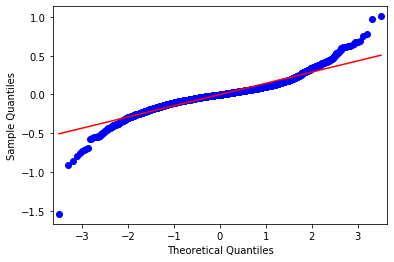

In [12]:
# Residual plot - qq plot
fig = sm.qqplot(residuals_fe_2000_co2_total_df['residual'], line="s")
plt.show()

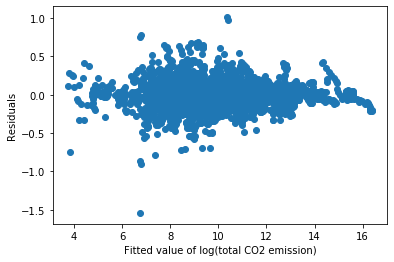

In [13]:
# Residual plot - plot of residual vs fitted value
plt.scatter(residuals_fe_2000_co2_total_df['predicted'],residuals_fe_2000_co2_total_df['residual'])
plt.xlabel('Fitted value of log(total CO2 emission)')
plt.ylabel('Residuals')
plt.show()

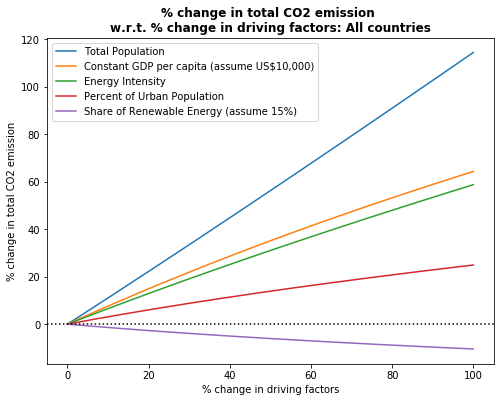

In [14]:
# Visualize elasticity effect
elasticity_df=pd.DataFrame()
x_2=np.arange(start=0, stop=1.0001, step=0.0001)
gdp_per_capita=np.arange(start=10000,stop=20001,step=1)
renew_share=np.arange(start=15, stop=30.0015, step=0.0015)
x=(x_2+1).tolist()
elasticity_df['factor']=x
elasticity_df['gdp_per_capita']=gdp_per_capita
elasticity_df['renew_share']=renew_share
elasticity_df['co2_gdp']=np.exp(np.log(elasticity_df['gdp_per_capita'])*model_fe_2000_co2_total_result.params[2]
                                       +np.log(elasticity_df['gdp_per_capita'])*np.log(elasticity_df['gdp_per_capita'])*model_fe_2000_co2_total_result.params[3])
elasticity_df['gdp_growth']=(elasticity_df['gdp_per_capita']/elasticity_df.loc[0,'gdp_per_capita']-1)*100
elasticity_df['co2_gdp_growth']=(elasticity_df['co2_gdp']/elasticity_df.loc[0,'co2_gdp']-1)*100
elasticity_df['population']=elasticity_df['factor']**model_fe_2000_co2_total_result.params[0]
elasticity_df['energy_intensity']=elasticity_df['factor']**model_fe_2000_co2_total_result.params[4]
elasticity_df['urban_population_percent']=elasticity_df['factor']**model_fe_2000_co2_total_result.params[1]
elasticity_df['co2_renew']=np.exp(np.log(elasticity_df['renew_share'])*model_fe_2000_co2_total_result.params[7]
                                       +np.log(elasticity_df['renew_share'])*np.log(elasticity_df['renew_share'])*model_fe_2000_co2_total_result.params[8])
elasticity_df['renew_growth']=(elasticity_df['renew_share']/elasticity_df.loc[0,'renew_share']-1)*100
elasticity_df['co2_renew_growth']=(elasticity_df['co2_renew']/elasticity_df.loc[0,'co2_renew']-1)*100

plt.figure(figsize=(8, 6))
plt.title('% change in total CO2 emission \nw.r.t. % change in driving factors: All countries',fontweight='bold')
plt.xlabel('% change in driving factors')
plt.ylabel('% change in total CO2 emission')
plt.plot((elasticity_df['factor']-1)*100,(elasticity_df['population']-1)*100)
plt.plot(elasticity_df['gdp_growth'],elasticity_df['co2_gdp_growth'])
plt.plot((elasticity_df['factor']-1)*100,(elasticity_df['energy_intensity']-1)*100)
plt.plot((elasticity_df['factor']-1)*100,(elasticity_df['urban_population_percent']-1)*100)
plt.plot(elasticity_df['renew_growth'],elasticity_df['co2_renew_growth'])
plt.axhline(y=0, color='black', linestyle='dotted')
plt.legend(labels=['Total Population','Constant GDP per capita (assume US$10,000)','Energy Intensity','Percent of Urban Population','Share of Renewable Energy (assume 15%)'])
plt.show()

In [15]:
# Total CO2 emission (cluster 0)
# Set dependent variables
exog=analysis_2000_df_cluster0[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_total_cluster0 = PanelOLS(analysis_2000_df_cluster0['log_total_co2'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_total_cluster0_result = model_fe_2000_co2_total_cluster0.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_total_cluster0_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_total_co2   R-squared:                        0.5670
Estimator:                   PanelOLS   R-squared (Between):             -6.6763
No. Observations:                1764   R-squared (Within):               0.7942
Date:                Sun, Dec 12 2021   R-squared (Overall):             -5.6991
Time:                        23:26:42   Log-likelihood                    485.62
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      235.66
Entities:                          86   P-value                           0.0000
Avg Obs:                       20.512   Distribution:                  F(9,1620)
Min Obs:                       1.0000                                           
Max Obs:                       50.000   F-statistic (robust):             45.113
                            

In [16]:
# Test for Model (Cluster 0)
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_total_cluster0 = RandomEffects(analysis_2000_df_cluster0['log_total_co2'], exog) 
re_res = model_re_2000_co2_total_cluster0.fit(cov_type='robust') 
hausman_results = hausman(model_fe_2000_co2_total_cluster0_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 134.78009496950034
degrees of freedom: 9
p Value: 1.2306007773946257e-24


In [17]:
residuals_fe_2000_co2_total_cluster0 = model_fe_2000_co2_total_cluster0_result.resids
residuals_fe_2000_co2_total_cluster0_df=residuals_fe_2000_co2_total_cluster0.to_frame().reset_index()
residuals_fe_2000_co2_total_cluster0_df=pd.merge(residuals_fe_2000_co2_total_cluster0_df,analysis_2000_df2[['log_total_co2','iso_code','year']],how='left',on=['iso_code','year']) 
residuals_fe_2000_co2_total_cluster0_df['predicted']=residuals_fe_2000_co2_total_cluster0_df['log_total_co2']-residuals_fe_2000_co2_total_cluster0_df['residual']

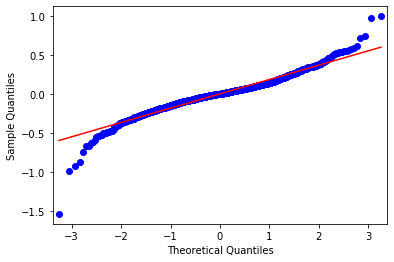

In [18]:
# Residual plot - qq plot (cluster 0)
fig = sm.qqplot(residuals_fe_2000_co2_total_cluster0_df['residual'], line="s")
plt.show()

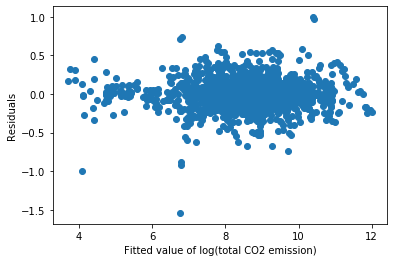

In [19]:
# Residual plot - plot of residual vs fitted value (cluster 0)
plt.scatter(residuals_fe_2000_co2_total_cluster0_df['predicted'],residuals_fe_2000_co2_total_cluster0_df['residual'])
plt.xlabel('Fitted value of log(total CO2 emission)')
plt.ylabel('Residuals')
plt.show()

In [20]:
# Total CO2 emission (cluster 1)
# Set dependent variables
exog=analysis_2000_df_cluster1[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_total_cluster1 = PanelOLS(analysis_2000_df_cluster1['log_total_co2'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_total_cluster1_result = model_fe_2000_co2_total_cluster1.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_total_cluster1_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_total_co2   R-squared:                        0.9994
Estimator:                   PanelOLS   R-squared (Between):             -20.063
No. Observations:                  81   R-squared (Within):              -2.0639
Date:                Sun, Dec 12 2021   R-squared (Overall):             -19.796
Time:                        23:26:43   Log-likelihood                    301.63
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3643.5
Entities:                           2   P-value                           0.0000
Avg Obs:                       40.500   Distribution:                    F(9,21)
Min Obs:                       31.000                                           
Max Obs:                       50.000   F-statistic (robust):             5617.8
                            

In [21]:
# Test for Model (Cluster 1)
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_total_cluster1 = RandomEffects(analysis_2000_df_cluster1['log_total_co2'], exog) 
re_res = model_re_2000_co2_total_cluster1.fit(cov_type='robust') 
hausman_results = hausman(model_fe_2000_co2_total_cluster1_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 115.54530281900675
degrees of freedom: 9
p Value: 1.088139754912148e-20


In [22]:
residuals_fe_2000_co2_total_cluster1 = model_fe_2000_co2_total_cluster1_result.resids
residuals_fe_2000_co2_total_cluster1_df=residuals_fe_2000_co2_total_cluster1.to_frame().reset_index()
residuals_fe_2000_co2_total_cluster1_df=pd.merge(residuals_fe_2000_co2_total_cluster1_df,analysis_2000_df2[['log_total_co2','iso_code','year']],how='left',on=['iso_code','year']) 
residuals_fe_2000_co2_total_cluster1_df['predicted']=residuals_fe_2000_co2_total_cluster1_df['log_total_co2']-residuals_fe_2000_co2_total_cluster1_df['residual']

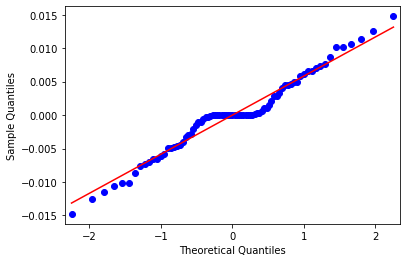

In [23]:
# Residual plot - qq plot
fig = sm.qqplot(residuals_fe_2000_co2_total_cluster1_df['residual'], line="s")
plt.show()

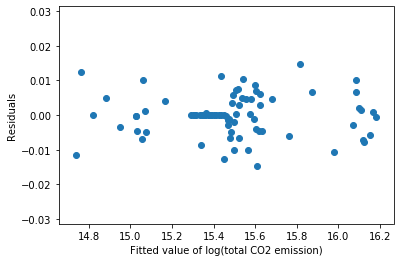

In [24]:
# Residual plot - plot of residual vs fitted value (cluster 1)
plt.scatter(residuals_fe_2000_co2_total_cluster1_df['predicted'],residuals_fe_2000_co2_total_cluster1_df['residual'])
plt.xlabel('Fitted value of log(total CO2 emission)')
plt.ylabel('Residuals')
plt.show()

In [25]:
# Total emission (cluster 2)
exog=analysis_2000_df_cluster2[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_total_cluster2 = PanelOLS(analysis_2000_df_cluster2['log_total_co2'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_total_cluster2_result = model_fe_2000_co2_total_cluster2.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_total_cluster2_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_total_co2   R-squared:                        0.8732
Estimator:                   PanelOLS   R-squared (Between):             -2.0259
No. Observations:                2631   R-squared (Within):               0.8525
Date:                Sun, Dec 12 2021   R-squared (Overall):             -2.0020
Time:                        23:26:44   Log-likelihood                    2509.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1913.2
Entities:                          72   P-value                           0.0000
Avg Obs:                       36.542   Distribution:                  F(9,2501)
Min Obs:                       7.0000                                           
Max Obs:                       50.000   F-statistic (robust):             185.40
                            

In [26]:
# Test for Model (Cluster 2)
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_total_cluster2 = RandomEffects(analysis_2000_df_cluster2['log_total_co2'], exog) 
re_res = model_re_2000_co2_total_cluster2.fit(cov_type='robust') 
hausman_results = hausman(model_fe_2000_co2_total_cluster2_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 121.36202832563443
degrees of freedom: 9
p Value: 7.030135509292098e-22


In [27]:
residuals_fe_2000_co2_total_cluster2 = re_res.resids
residuals_fe_2000_co2_total_cluster2_df=residuals_fe_2000_co2_total_cluster2.to_frame().reset_index()
residuals_fe_2000_co2_total_cluster2_df=pd.merge(residuals_fe_2000_co2_total_cluster2_df,analysis_2000_df2[['log_total_co2','iso_code','year']],how='left',on=['iso_code','year']) 
residuals_fe_2000_co2_total_cluster2_df['predicted']=residuals_fe_2000_co2_total_cluster2_df['log_total_co2']-residuals_fe_2000_co2_total_cluster2_df['residual']

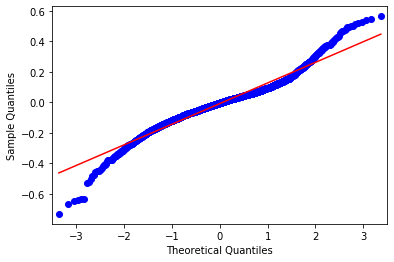

In [28]:
# Residual plot - qq plot (cluster 2)
fig = sm.qqplot(residuals_fe_2000_co2_total_cluster2_df['residual'], line="s")
plt.show()

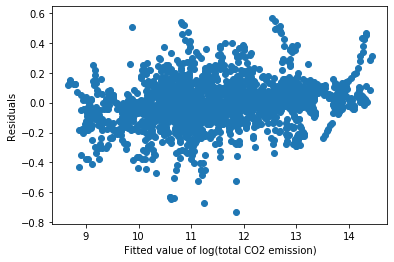

In [29]:
# Residual plot - plot of residual vs fitted value (cluster 2)
plt.scatter(residuals_fe_2000_co2_total_cluster2_df['predicted'],residuals_fe_2000_co2_total_cluster2_df['residual'])
plt.xlabel('Fitted value of log(total CO2 emission)')
plt.ylabel('Residuals')
plt.show()

In [30]:
# Total emission (clusters 1 and 2)
exog=analysis_2000_df_cluster12[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_total_cluster12 = PanelOLS(analysis_2000_df_cluster12['log_total_co2'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_total_cluster12_result = model_fe_2000_co2_total_cluster12.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_total_cluster12_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:          log_total_co2   R-squared:                        0.8753
Estimator:                   PanelOLS   R-squared (Between):             -1.8774
No. Observations:                2712   R-squared (Within):               0.8602
Date:                Sun, Dec 12 2021   R-squared (Overall):             -1.8492
Time:                        23:26:45   Log-likelihood                    2606.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2012.5
Entities:                          74   P-value                           0.0000
Avg Obs:                       36.649   Distribution:                  F(9,2580)
Min Obs:                       7.0000                                           
Max Obs:                       50.000   F-statistic (robust):             190.98
                            

In [31]:
# Test for Model (Cluster 1 and 2)
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_total_cluster12 = RandomEffects(analysis_2000_df_cluster12['log_total_co2'], exog) 
re_res = model_re_2000_co2_total_cluster12.fit(cov_type='robust') 
hausman_results = hausman(model_fe_2000_co2_total_cluster12_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 120.94811435161341
degrees of freedom: 9
p Value: 8.545524414022705e-22


In [32]:
residuals_fe_2000_co2_total_cluster12 = model_fe_2000_co2_total_cluster12_result.resids
residuals_fe_2000_co2_total_cluster12_df=residuals_fe_2000_co2_total_cluster12.to_frame().reset_index()
residuals_fe_2000_co2_total_cluster12_df=pd.merge(residuals_fe_2000_co2_total_cluster12_df,analysis_2000_df2[['log_total_co2','iso_code','year']],how='left',on=['iso_code','year']) 
residuals_fe_2000_co2_total_cluster12_df['predicted']=residuals_fe_2000_co2_total_cluster12_df['log_total_co2']-residuals_fe_2000_co2_total_cluster12_df['residual']

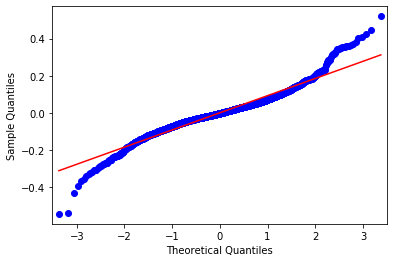

In [33]:
# Residual plot - qq plot (clusters 1 and 2)
fig = sm.qqplot(residuals_fe_2000_co2_total_cluster12_df['residual'], line="s")
plt.show()

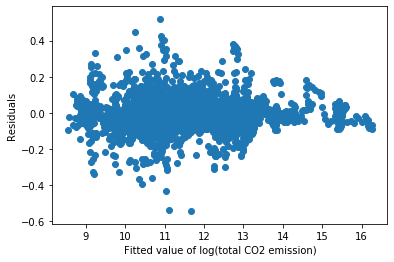

In [34]:
# Residual plot - plot of residual vs fitted value (clusters 1 and 2)
plt.scatter(residuals_fe_2000_co2_total_cluster12_df['predicted'],residuals_fe_2000_co2_total_cluster12_df['residual'])
plt.xlabel('Fitted value of log(total CO2 emission)')
plt.ylabel('Residuals')
plt.show()

### Check total CO2 emission of clusters 0, 1, 2 in 2020

In [35]:
# Check total CO2 emmision of clusters 0, 1, 2
c0_df=analysis_2000_df2_cluster0.groupby(['year'])['co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share'].sum().reset_index()
c0_2020_df=c0_df[c0_df['year']==2020]
c0_2020_df['cluster']='cluster 0'
c0_2020_df=c0_2020_df[['year','cluster','co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share']]
c0_2020_df['co2']

49    768610.0
Name: co2, dtype: float64

In [36]:
c1_df=analysis_2000_df2_cluster1.groupby(['year'])['co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share'].sum().reset_index()
c1_2020_df=c1_df[c1_df['year']==2020]
c1_2020_df['cluster']='cluster 1'
c1_2020_df=c1_2020_df[['year','cluster','co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share']]
c1_2020_df['co2']

49    15380658.0
Name: co2, dtype: float64

In [37]:
c2_df=analysis_2000_df2_cluster2.groupby(['year'])['co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share'].sum().reset_index()
c2_2020_df=c2_df[c2_df['year']==2020]
c2_2020_df['cluster']='cluster 2'
c2_2020_df=c2_2020_df[['year','cluster','co2','population','constant_gdp_per_capita','energy_intensity','manufacturing_percent','trade_openness','renewable_energy_consumption_share']]
c2_2020_df['co2']

49    14853279.0
Name: co2, dtype: float64

### Out sample prediction

In [38]:
# Convert the forecast pickle file into format in need
forecast_input_lst = pd.read_pickle('C:/Users/hhfwong/power-emissions-main/data/processed/ts_forecast.pkl') #Need to change file path

c0_population_array=forecast_input_lst[14][2]
c0_gdp_pc_array=forecast_input_lst[4][2]
c0_ei_array=forecast_input_lst[21][2]
c0_manufacturing_percent_array=forecast_input_lst[7][2]
c0_trade_array=forecast_input_lst[0][2]
c0_renew_percent_array=forecast_input_lst[10][2]
c0_co2_array=forecast_input_lst[5][2]

c1_population_array=forecast_input_lst[18][2]
c1_gdp_pc_array=forecast_input_lst[9][2]
c1_ei_array=forecast_input_lst[15][2]
c1_manufacturing_percent_array=forecast_input_lst[13][2]
c1_trade_array=forecast_input_lst[27][2]
c1_renew_percent_array=forecast_input_lst[12][2]
c1_co2_array=forecast_input_lst[11][2]

c2_population_array=forecast_input_lst[25][2]
c2_gdp_pc_array=forecast_input_lst[17][2]
c2_ei_array=forecast_input_lst[8][2]
c2_manufacturing_percent_array=forecast_input_lst[1][2]
c2_trade_array=forecast_input_lst[23][2]
c2_renew_percent_array=forecast_input_lst[16][2]
c2_co2_array=forecast_input_lst[2][2]

all_population_array=forecast_input_lst[3][2]
all_gdp_pc_array=forecast_input_lst[20][2]
all_ei_array=forecast_input_lst[22][2]
all_manufacturing_percent_array=forecast_input_lst[19][2]
all_trade_array=forecast_input_lst[6][2]
all_renew_percent_array=forecast_input_lst[24][2]
all_co2_array=forecast_input_lst[26][2]

c0_population_df = pd.DataFrame(c0_population_array,columns=['year','population'])
c0_population_df['year'].astype(int)
c0_gdp_pc_df = pd.DataFrame(c0_gdp_pc_array,columns=['year','constant_gdp_per_capita'])
c0_gdp_pc_df['year'].astype(int)
c0_ei_df = pd.DataFrame(c0_ei_array,columns=['year','energy_intensity'])
c0_ei_df['year'].astype(int)
c0_manufacturing_percent_df = pd.DataFrame(c0_manufacturing_percent_array,columns=['year','manufacturing_percent'])
c0_manufacturing_percent_df['year'].astype(int)
c0_trade_df = pd.DataFrame(c0_trade_array,columns=['year','trade_openness'])
c0_trade_df['year'].astype(int)
c0_renew_percent_df = pd.DataFrame(c0_renew_percent_array,columns=['year','renewable_energy_consumption_share'])
c0_renew_percent_df['year'].astype(int)
c0_forecast_input_df=c0_population_df.merge(c0_gdp_pc_df,how='left',on=['year'])
c0_forecast_input_df=c0_forecast_input_df.merge(c0_ei_df,how='left',on=['year'])
c0_forecast_input_df=c0_forecast_input_df.merge(c0_manufacturing_percent_df,how='left',on=['year'])
c0_forecast_input_df=c0_forecast_input_df.merge(c0_trade_df,how='left',on=['year'])
c0_forecast_input_df=c0_forecast_input_df.merge(c0_renew_percent_df,how='left',on=['year'])
c0_forecast_input_df['cluster']='cluster 0'
c0_forecast_input_df.drop(['year'],axis=1,inplace=True)
c0_forecast_input_df['year']=[2021,2022,2023,2024,2025]
c0_forecast_input_df['population_lag4']=c0_forecast_input_df['population'].shift(4)
c0_forecast_input_df['constant_gdp_per_capita_lag4']=c0_forecast_input_df['constant_gdp_per_capita'].shift(4)
c0_forecast_input_df['energy_intensity_lag4']=c0_forecast_input_df['energy_intensity'].shift(4)
c0_forecast_input_df['manufacturing_percent_lag4']=c0_forecast_input_df['manufacturing_percent'].shift(4)
c0_forecast_input_df['trade_openness_lag4']=c0_forecast_input_df['trade_openness'].shift(4)
c0_forecast_input_df['renewable_energy_consumption_share_lag4']=c0_forecast_input_df['renewable_energy_consumption_share'].shift(4)
c0_forecast_input_df['population_growth']=c0_forecast_input_df['population']/c0_forecast_input_df['population_lag4']
c0_forecast_input_df['constant_gdp_per_capita_growth']=c0_forecast_input_df['constant_gdp_per_capita']/c0_forecast_input_df['constant_gdp_per_capita_lag4']
c0_forecast_input_df['energy_intensity_growth']=c0_forecast_input_df['energy_intensity']/c0_forecast_input_df['energy_intensity_lag4']
c0_forecast_input_df['manufacturing_percent_growth']=c0_forecast_input_df['manufacturing_percent']/c0_forecast_input_df['manufacturing_percent_lag4']
c0_forecast_input_df['trade_openness_growth']=c0_forecast_input_df['trade_openness']/c0_forecast_input_df['trade_openness_lag4']
c0_forecast_input_df['renewable_energy_consumption_share_growth']=c0_forecast_input_df['renewable_energy_consumption_share']/c0_forecast_input_df['renewable_energy_consumption_share_lag4']

c0_population_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'population_growth']
c0_constant_gdp_per_capita_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'constant_gdp_per_capita_growth']
c0_energy_intensity_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'energy_intensity_growth']
c0_manufacturing_percent_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'manufacturing_percent_growth']
c0_trade_openness_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'trade_openness_growth']
c0_renewable_energy_consumption_share_growth=c0_forecast_input_df.loc[c0_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'renewable_energy_consumption_share_growth']

c1_population_df = pd.DataFrame(c1_population_array,columns=['year','population'])
c1_population_df['year'].astype(int)
c1_gdp_pc_df = pd.DataFrame(c1_gdp_pc_array,columns=['year','constant_gdp_per_capita'])
c1_gdp_pc_df['year'].astype(int)
c1_ei_df = pd.DataFrame(c1_ei_array,columns=['year','energy_intensity'])
c1_ei_df['year'].astype(int)
c1_manufacturing_percent_df = pd.DataFrame(c1_manufacturing_percent_array,columns=['year','manufacturing_percent'])
c1_manufacturing_percent_df['year'].astype(int)
c1_trade_df = pd.DataFrame(c1_trade_array,columns=['year','trade_openness'])
c1_trade_df['year'].astype(int)
c1_renew_percent_df = pd.DataFrame(c1_renew_percent_array,columns=['year','renewable_energy_consumption_share'])
c1_renew_percent_df['year'].astype(int)
c1_forecast_input_df=c1_population_df.merge(c1_gdp_pc_df,how='left',on=['year'])
c1_forecast_input_df=c1_forecast_input_df.merge(c1_ei_df,how='left',on=['year'])
c1_forecast_input_df=c1_forecast_input_df.merge(c1_manufacturing_percent_df,how='left',on=['year'])
c1_forecast_input_df=c1_forecast_input_df.merge(c1_trade_df,how='left',on=['year'])
c1_forecast_input_df=c1_forecast_input_df.merge(c1_renew_percent_df,how='left',on=['year'])
c1_forecast_input_df['cluster']='cluster 1'
c1_forecast_input_df.drop(['year'],axis=1,inplace=True)
c1_forecast_input_df['year']=[2021,2022,2023,2024,2025]
c1_forecast_input_df['population_lag4']=c1_forecast_input_df['population'].shift(4)
c1_forecast_input_df['constant_gdp_per_capita_lag4']=c1_forecast_input_df['constant_gdp_per_capita'].shift(4)
c1_forecast_input_df['energy_intensity_lag4']=c1_forecast_input_df['energy_intensity'].shift(4)
c1_forecast_input_df['manufacturing_percent_lag4']=c1_forecast_input_df['manufacturing_percent'].shift(4)
c1_forecast_input_df['trade_openness_lag4']=c1_forecast_input_df['trade_openness'].shift(4)
c1_forecast_input_df['renewable_energy_consumption_share_lag4']=c1_forecast_input_df['renewable_energy_consumption_share'].shift(4)
c1_forecast_input_df['population_growth']=c1_forecast_input_df['population']/c1_forecast_input_df['population_lag4']
c1_forecast_input_df['constant_gdp_per_capita_growth']=c1_forecast_input_df['constant_gdp_per_capita']/c1_forecast_input_df['constant_gdp_per_capita_lag4']
c1_forecast_input_df['energy_intensity_growth']=c1_forecast_input_df['energy_intensity']/c1_forecast_input_df['energy_intensity_lag4']
c1_forecast_input_df['manufacturing_percent_growth']=c1_forecast_input_df['manufacturing_percent']/c1_forecast_input_df['manufacturing_percent_lag4']
c1_forecast_input_df['trade_openness_growth']=c1_forecast_input_df['trade_openness']/c1_forecast_input_df['trade_openness_lag4']
c1_forecast_input_df['renewable_energy_consumption_share_growth']=c1_forecast_input_df['renewable_energy_consumption_share']/c1_forecast_input_df['renewable_energy_consumption_share_lag4']

c1_population_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'population_growth']
c1_constant_gdp_per_capita_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'constant_gdp_per_capita_growth']
c1_energy_intensity_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'energy_intensity_growth']
c1_manufacturing_percent_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'manufacturing_percent_growth']
c1_trade_openness_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'trade_openness_growth']
c1_renewable_energy_consumption_share_growth=c1_forecast_input_df.loc[c1_forecast_input_df.index[(c1_forecast_input_df['year']==2025)][0],'renewable_energy_consumption_share_growth']

c2_population_df = pd.DataFrame(c2_population_array,columns=['year','population'])
c2_population_df['year'].astype(int)
c2_gdp_pc_df = pd.DataFrame(c2_gdp_pc_array,columns=['year','constant_gdp_per_capita'])
c2_gdp_pc_df['year'].astype(int)
c2_ei_df = pd.DataFrame(c2_ei_array,columns=['year','energy_intensity'])
c2_ei_df['year'].astype(int)
c2_manufacturing_percent_df = pd.DataFrame(c2_manufacturing_percent_array,columns=['year','manufacturing_percent'])
c2_manufacturing_percent_df['year'].astype(int)
c2_trade_df = pd.DataFrame(c2_trade_array,columns=['year','trade_openness'])
c2_trade_df['year'].astype(int)
c2_renew_percent_df = pd.DataFrame(c2_renew_percent_array,columns=['year','renewable_energy_consumption_share'])
c2_renew_percent_df['year'].astype(int)
c2_forecast_input_df=c2_population_df.merge(c2_gdp_pc_df,how='left',on=['year'])
c2_forecast_input_df=c2_forecast_input_df.merge(c2_ei_df,how='left',on=['year'])
c2_forecast_input_df=c2_forecast_input_df.merge(c2_manufacturing_percent_df,how='left',on=['year'])
c2_forecast_input_df=c2_forecast_input_df.merge(c2_trade_df,how='left',on=['year'])
c2_forecast_input_df=c2_forecast_input_df.merge(c2_renew_percent_df,how='left',on=['year'])
c2_forecast_input_df['cluster']='cluster 2'
c2_forecast_input_df.drop(['year'],axis=1,inplace=True)
c2_forecast_input_df['year']=[2021,2022,2023,2024,2025]
c2_forecast_input_df['population_lag4']=c2_forecast_input_df['population'].shift(4)
c2_forecast_input_df['constant_gdp_per_capita_lag4']=c2_forecast_input_df['constant_gdp_per_capita'].shift(4)
c2_forecast_input_df['energy_intensity_lag4']=c2_forecast_input_df['energy_intensity'].shift(4)
c2_forecast_input_df['manufacturing_percent_lag4']=c2_forecast_input_df['manufacturing_percent'].shift(4)
c2_forecast_input_df['trade_openness_lag4']=c2_forecast_input_df['trade_openness'].shift(4)
c2_forecast_input_df['renewable_energy_consumption_share_lag4']=c2_forecast_input_df['renewable_energy_consumption_share'].shift(4)
c2_forecast_input_df['population_growth']=c2_forecast_input_df['population']/c2_forecast_input_df['population_lag4']
c2_forecast_input_df['constant_gdp_per_capita_growth']=c2_forecast_input_df['constant_gdp_per_capita']/c2_forecast_input_df['constant_gdp_per_capita_lag4']
c2_forecast_input_df['energy_intensity_growth']=c2_forecast_input_df['energy_intensity']/c2_forecast_input_df['energy_intensity_lag4']
c2_forecast_input_df['manufacturing_percent_growth']=c2_forecast_input_df['manufacturing_percent']/c2_forecast_input_df['manufacturing_percent_lag4']
c2_forecast_input_df['trade_openness_growth']=c2_forecast_input_df['trade_openness']/c2_forecast_input_df['trade_openness_lag4']
c2_forecast_input_df['renewable_energy_consumption_share_growth']=c2_forecast_input_df['renewable_energy_consumption_share']/c2_forecast_input_df['renewable_energy_consumption_share_lag4']

c2_population_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'population_growth']
c2_constant_gdp_per_capita_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'constant_gdp_per_capita_growth']
c2_energy_intensity_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'energy_intensity_growth']
c2_manufacturing_percent_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'manufacturing_percent_growth']
c2_trade_openness_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'trade_openness_growth']
c2_renewable_energy_consumption_share_growth=c2_forecast_input_df.loc[c2_forecast_input_df.index[(c2_forecast_input_df['year']==2025)][0],'renewable_energy_consumption_share_growth']

print(c0_population_growth,c0_constant_gdp_per_capita_growth,c0_energy_intensity_growth,c0_manufacturing_percent_growth,c0_trade_openness_growth,c0_renewable_energy_consumption_share_growth)
print(c1_population_growth,c1_constant_gdp_per_capita_growth,c1_energy_intensity_growth,c1_manufacturing_percent_growth,c1_trade_openness_growth,c1_renewable_energy_consumption_share_growth)
print(c2_population_growth,c2_constant_gdp_per_capita_growth,c2_energy_intensity_growth,c2_manufacturing_percent_growth,c2_trade_openness_growth,c2_renewable_energy_consumption_share_growth)

1.085303506944013 1.0 0.8981892348209959 1.0 1.0 1.0
1.0127822667021247 1.049730742442808 0.9343765077202206 1.0 1.0558203849793912 1.1262928531872587
1.034046351338729 1.0357236936517524 0.9192906344189398 0.968351951809788 1.0539136330378958 1.1221007968004508


In [39]:
# Get the entity and time parameters as well - all clusters
co2_pc_exog_vars_hand=['iso_code','year','log_population','log_urban_percent','log_gdp_per_capita','log_gdp_per_capita_sq','log_energy_intensity',
                       'log_manufacturing_share','log_trade','log_renewable_share','log_renewable_share_sq'
                      ]
features_use=['iso_code','year','log_population','log_urban_percent','log_gdp_per_capita','log_gdp_per_capita_sq','log_energy_intensity',
              'log_manufacturing_share','log_trade','log_renewable_share','log_renewable_share_sq',
              'log_total_co2','log_co2_per_capita','log_co2_intensity']
predict_hand_df=analysis_2000_df2.copy(deep=True)
predict_hand_df=predict_hand_df.dropna(subset=['log_total_co2','log_population','log_urban_percent','log_gdp_per_capita','log_gdp_per_capita_sq','log_energy_intensity',
                              'log_manufacturing_share','log_trade','log_renewable_share','log_renewable_share_sq',
                              ])
exog_hand=predict_hand_df[co2_pc_exog_vars_hand]
country_lst=list(exog_hand['iso_code'].unique())[:]

for i in range(1971,2021):
    exog_hand[i]=np.where(exog_hand['year']==i,1,0)
for country in country_lst:
    exog_hand[country]=np.where(exog_hand['iso_code']==country,1,0)
exog_hand.columns=exog_hand.columns.astype(str)    
exog_hand.drop(['year'],axis=1,inplace=True)
exog_hand2=exog_hand.copy(deep=True)
exog_hand.drop(['iso_code'],axis=1,inplace=True)
mod_2000_co2_pc = sm.OLS(predict_hand_df['log_total_co2'],sm.add_constant(exog_hand).astype(float))
mod_2000_co2_pc_res = mod_2000_co2_pc.fit(cov_type='HC3')
print(mod_2000_co2_pc_res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_total_co2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.421e+05
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:26:46   Log-Likelihood:                 2310.6
No. Observations:                4476   AIC:                            -4185.
Df Residuals:                    4258   BIC:                            -2788.
Df Model:                         217                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

C:\Users\hhfwong\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 219, but rank is 217
  'rank is %d' % (J, J_), ValueWarning)


In [40]:
# Check residuals correctness
exog_hand_CHN = exog_hand2[exog_hand2['iso_code'] == 'CHN']
exog_hand_CHN.replace('CHN', 1, inplace=True)
mod_2000_co2_pc_params=mod_2000_co2_pc_res.params
in_sample_predict_hand_CHN=mod_2000_co2_pc_res.predict(exog=exog_hand_CHN)
in_sample_predict_hand_CHN=in_sample_predict_hand_CHN.to_frame()
in_sample_predict_hand_CHN.columns=['predicted']
year_lst=list(range(1990,2021))
in_sample_predict_hand_CHN['year']=year_lst
from itertools import repeat
given_value ='CHN'
new_list=[]
new_list.extend(repeat(given_value,31))
in_sample_predict_hand_CHN['iso_code']=new_list
in_sample_predict_hand_CHN
# Compare true and predict value
analysis_2000_df2_CHN = analysis_2000_df2[analysis_2000_df2['iso_code']=='CHN']
true_hand_CHN=analysis_2000_df2_CHN[['log_total_co2','iso_code','year']]
compare_CHN=pd.merge(true_hand_CHN,in_sample_predict_hand_CHN,how='left',on=['iso_code','year'])
compare_CHN[['iso_code','year','log_total_co2','predicted']]
compare_CHN['residual']=compare_CHN['log_total_co2']-compare_CHN['predicted']

In [41]:
residuals_fe_2000_co2_total_df[residuals_fe_2000_co2_total_df['iso_code']=='CHN']['residual']

567     0.412493
686     0.421639
790     0.347005
895     0.296472
1006    0.259635
1120    0.215405
1242    0.184116
1364    0.148834
1486    0.079871
1608    0.034283
1731   -0.007194
1857   -0.054828
1983   -0.041527
2110   -0.052131
2241   -0.059694
2390   -0.059228
2541   -0.058757
2692   -0.090060
2840   -0.067000
2968   -0.080296
3096   -0.115139
3225   -0.096966
3355   -0.114550
3485   -0.130341
3617   -0.166391
3747   -0.182283
3875   -0.194919
4002   -0.208145
4130   -0.202093
4258   -0.218341
4382   -0.199873
Name: residual, dtype: float64

In [42]:
# Prepare matrix X
d1=exog_hand2[exog_hand2['2020']==1]
d1['cluster']=np.where(d1['iso_code'].isin(country_gp0),'cluster 0',0)
d1['cluster']=np.where(d1['iso_code'].isin(country_gp1),'cluster 1',d1['cluster'])
d1['cluster']=np.where(d1['iso_code'].isin(country_gp2),'cluster 2',d1['cluster'])
d1=d1.reset_index()
d1.drop(['index'],axis=1,inplace=True)

dict0={'log_population':c0_population_growth,'log_urban_percent':1,'log_gdp_per_capita':c0_constant_gdp_per_capita_growth,'log_energy_intensity':c0_energy_intensity_growth,'log_manufacturing_share':c0_manufacturing_percent_growth,'log_trade':c0_trade_openness_growth,'log_renewable_share':c0_renewable_energy_consumption_share_growth}
dict1={'log_population':c1_population_growth,'log_urban_percent':1,'log_gdp_per_capita':c1_constant_gdp_per_capita_growth,'log_energy_intensity':c1_energy_intensity_growth,'log_manufacturing_share':c1_manufacturing_percent_growth,'log_trade':c1_trade_openness_growth,'log_renewable_share':c1_renewable_energy_consumption_share_growth}
dict2={'log_population':c2_population_growth,'log_urban_percent':1,'log_gdp_per_capita':c2_constant_gdp_per_capita_growth,'log_energy_intensity':c2_energy_intensity_growth,'log_manufacturing_share':c2_manufacturing_percent_growth,'log_trade':c2_trade_openness_growth,'log_renewable_share':c2_renewable_energy_consumption_share_growth}
feature_list=['log_population','log_urban_percent','log_gdp_per_capita','log_energy_intensity','log_manufacturing_share','log_trade','log_renewable_share']

d1['2025']=0
for name in feature_list:
    for i in range(113):
        if d1.loc[i,'cluster']=='cluster 0':
            d1.loc[i+113,name]=np.log(np.exp(d1.loc[i,name])*dict0[name])
            d1.loc[i+113,'cluster']='cluster 0'
        elif d1.loc[i,'cluster']=='cluster 1':
            d1.loc[i+113,name]=np.log(np.exp(d1.loc[i,name])*dict1[name])
            d1.loc[i+113,'cluster']='cluster 1'
        else:
            d1.loc[i+113,name]=np.log(np.exp(d1.loc[i,name])*dict2[name])
            d1.loc[i+113,'cluster']='cluster 2'
        iso_code_temp=d1.loc[i,'iso_code']
        d1.loc[i+113,iso_code_temp]=1
        d1.loc[i+113,'2025']=1
        d1.loc[i+113,'iso_code']=iso_code_temp
d1['log_gdp_per_capita_sq']=d1['log_gdp_per_capita']**2
d1['log_renewable_share_sq']=d1['log_renewable_share']**2
d1=d1.fillna(0)
d1=d1.tail(113)
predict_result_df1=d1[['iso_code','cluster']].reset_index()
predict_result_df1.drop(['index'],axis=1,inplace=True)
d1.drop(['iso_code','cluster'],axis=1,inplace=True)
col_remove_list=list(range(1971, 2021))
str_col_remove_list = [str(int) for int in col_remove_list]
d1.drop(str_col_remove_list,axis=1,inplace=True)
col_list=d1.columns.tolist()
d1['constant']=1
# Convert to array
d1_array = d1.to_numpy()
d1_array.shape

(113, 171)

In [43]:
# Prepare beta
sum_param_2025=0
for i in range(50):
    sum_param_2025=sum_param_2025+(mod_2000_co2_pc_res.params[[i+10]][0])
param_2025=sum_param_2025/50
beta_list=[]
for i in range(9):
    beta_list.append(mod_2000_co2_pc_res.params[[i+1]][0])
for i in range(160):
    beta_list.append(mod_2000_co2_pc_res.params[[i+60]][0])
beta_list.append(param_2025)
beta_list.append(mod_2000_co2_pc_res.params[[0]][0])
beta_array=np.array(beta_list)
beta_array.shape

(171,)

In [44]:
# y = Xb Calculate predicted log total Co2
y_hat_array=np.exp(np.matmul(d1_array,beta_array))
y_hat_array

array([3.25655307e+04, 5.75320995e+03, 1.80471709e+05, 6.51656089e+03,
       3.91299837e+05, 6.36297614e+04, 5.34511834e+04, 1.00359838e+05,
       7.56189684e+03, 1.16845769e+05, 4.33661937e+04, 2.28680721e+04,
       6.68438969e+04, 4.83624762e+05, 1.20238243e+04, 7.07563187e+03,
       6.26129644e+05, 4.02272215e+04, 8.61355681e+04, 1.44763742e+07,
       8.51035896e+03, 3.46117742e+03, 2.61887744e+03, 1.05558973e+05,
       1.05116810e+04, 6.52790222e+03, 1.07452445e+05, 6.70948749e+05,
       3.61929314e+04, 2.82598400e+04, 1.87705554e+05, 3.98874219e+04,
       2.59980281e+05, 2.56655197e+05, 1.39394921e+04, 1.73670329e+04,
       5.24570573e+04, 3.93304141e+05, 8.51250822e+03, 3.72848624e+05,
       1.00716842e+04, 6.43416406e+04, 1.98334555e+04, 3.78724123e+04,
       1.07575387e+04, 1.84010625e+04, 3.51178971e+03, 5.37358440e+04,
       6.07050036e+05, 2.97373637e+06, 3.06883166e+04, 7.64769603e+05,
       4.56520550e+03, 6.36414266e+04, 3.41754556e+05, 8.93186316e+03,
      

In [45]:
# Predict 2025 total CO2 emission using the panel regression model (using individual cluster figures) - total
#(Note: The figure is divided by 1000 to convert the unit from thousand tonne to million tonne for comparison with the time series forecast)
predict_result_df2=pd.DataFrame(y_hat_array,columns=['predict_total_co2'])
predict_result_df = pd.concat([predict_result_df1.reset_index(drop=True),predict_result_df2.reset_index(drop=True)], axis=1)
predict_total_co2 = (predict_result_df['predict_total_co2'].sum())/1000
predict_total_co2

37391.33928349763

In [46]:
# Predict 2025 total CO2 emission using the panel regression model (using individual cluster figures) - individual cluster
predict_cluster_co2 = predict_result_df.groupby(['cluster']).agg({'predict_total_co2':'sum'})
predict_cluster_co2['predict_total_co2']=predict_cluster_co2['predict_total_co2']/1000
predict_cluster_co2

,predict_total_co2
cluster,
cluster 0,784.020405
cluster 1,19664.193025
cluster 2,16943.125854


In [47]:
all_population_df = pd.DataFrame(all_population_array,columns=['year','population'])
all_population_df['year'].astype(int)
all_gdp_pc_df = pd.DataFrame(all_gdp_pc_array,columns=['year','constant_gdp_per_capita'])
all_gdp_pc_df['year'].astype(int)
all_ei_df = pd.DataFrame(all_ei_array,columns=['year','energy_intensity'])
all_ei_df['year'].astype(int)
all_manufacturing_percent_df = pd.DataFrame(all_manufacturing_percent_array,columns=['year','manufacturing_percent'])
all_manufacturing_percent_df['year'].astype(int)
all_trade_df = pd.DataFrame(all_trade_array,columns=['year','trade_openness'])
all_trade_df['year'].astype(int)
all_renew_percent_df = pd.DataFrame(all_renew_percent_array,columns=['year','renewable_energy_consumption_share'])
all_renew_percent_df['year'].astype(int)
all_forecast_input_df=all_population_df.merge(all_gdp_pc_df,how='left',on=['year'])
all_forecast_input_df=all_forecast_input_df.merge(all_ei_df,how='left',on=['year'])
all_forecast_input_df=all_forecast_input_df.merge(all_manufacturing_percent_df,how='left',on=['year'])
all_forecast_input_df=all_forecast_input_df.merge(all_trade_df,how='left',on=['year'])
all_forecast_input_df=all_forecast_input_df.merge(all_renew_percent_df,how='left',on=['year'])
all_forecast_input_df.drop(['year'],axis=1,inplace=True)
all_forecast_input_df['year']=[2021,2022,2023,2024,2025]
all_forecast_input_df['population_lag4']=all_forecast_input_df['population'].shift(4)
all_forecast_input_df['constant_gdp_per_capita_lag4']=all_forecast_input_df['constant_gdp_per_capita'].shift(4)
all_forecast_input_df['energy_intensity_lag4']=all_forecast_input_df['energy_intensity'].shift(4)
all_forecast_input_df['manufacturing_percent_lag4']=all_forecast_input_df['manufacturing_percent'].shift(4)
all_forecast_input_df['trade_openness_lag4']=all_forecast_input_df['trade_openness'].shift(4)
all_forecast_input_df['renewable_energy_consumption_share_lag4']=all_forecast_input_df['renewable_energy_consumption_share'].shift(4)
all_forecast_input_df['population_growth']=all_forecast_input_df['population']/all_forecast_input_df['population_lag4']
all_forecast_input_df['constant_gdp_per_capita_growth']=all_forecast_input_df['constant_gdp_per_capita']/all_forecast_input_df['constant_gdp_per_capita_lag4']
all_forecast_input_df['energy_intensity_growth']=all_forecast_input_df['energy_intensity']/all_forecast_input_df['energy_intensity_lag4']
all_forecast_input_df['manufacturing_percent_growth']=all_forecast_input_df['manufacturing_percent']/all_forecast_input_df['manufacturing_percent_lag4']
all_forecast_input_df['trade_openness_growth']=all_forecast_input_df['trade_openness']/all_forecast_input_df['trade_openness_lag4']
all_forecast_input_df['renewable_energy_consumption_share_growth']=all_forecast_input_df['renewable_energy_consumption_share']/all_forecast_input_df['renewable_energy_consumption_share_lag4']

all_population_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(all_forecast_input_df['year']==2025)][0],'population_growth']
all_constant_gdp_per_capita_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(all_forecast_input_df['year']==2025)][0],'constant_gdp_per_capita_growth']
all_energy_intensity_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(all_forecast_input_df['year']==2025)][0],'energy_intensity_growth']
all_manufacturing_percent_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(all_forecast_input_df['year']==2025)][0],'manufacturing_percent_growth']
all_trade_openness_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(all_forecast_input_df['year']==2025)][0],'trade_openness_growth']
all_renewable_energy_consumption_share_growth=all_forecast_input_df.loc[all_forecast_input_df.index[(c0_forecast_input_df['year']==2025)][0],'renewable_energy_consumption_share_growth']

print(all_population_growth,all_constant_gdp_per_capita_growth,all_energy_intensity_growth,all_manufacturing_percent_growth,all_trade_openness_growth,all_renewable_energy_consumption_share_growth)

1.0406225989402194 1.0 0.9051610151987738 0.9753337729881527 1.0 1.0


In [48]:
population_2025=all_population_array[4][1]
urban_population_percent_2025=data2.loc[data2.index[(data2['year']==2020)&(data2['iso_code']=='WLD')][0],'urban_population_percent']
constant_gdp_per_capita_2025=data2.loc[data2.index[(data2['year']==2020)&(data2['iso_code']=='WLD')][0],'constant_gdp_per_capita']*all_constant_gdp_per_capita_growth
energy_intensity_2025=data2.loc[data2.index[(data2['year']==2020)&(data2['iso_code']=='WLD')][0],'energy_intensity']*all_energy_intensity_growth
manufacturing_percent_2025=data2.loc[data2.index[(data2['year']==2020)&(data2['iso_code']=='WLD')][0],'manufacturing_percent']*all_manufacturing_percent_growth
trade_openness_2025=data2.loc[data2.index[(data2['year']==2020)&(data2['iso_code']=='WLD')][0],'trade_openness']*all_trade_openness_growth
renewable_energy_share_2025=data2.loc[data2.index[(data2['year']==2019)&(data2['iso_code']=='WLD')][0],'renewable_energy_consumption_share']*all_renewable_energy_consumption_share_growth

ln_population_2025=np.log(population_2025)
ln_urban_population_percent_2025=np.log(urban_population_percent_2025)
ln_constant_gdp_per_capita_2025=np.log(constant_gdp_per_capita_2025)
ln_constant_gdp_per_capita_sq_2025=np.log(constant_gdp_per_capita_2025)**2
ln_energy_intensity_2025=np.log(energy_intensity_2025)
ln_manufacturing_percent_2025=np.log(manufacturing_percent_2025)
ln_trade_openness_2025=np.log(trade_openness_2025)
ln_renewable_energy_share_2025=np.log(renewable_energy_share_2025)
ln_renewable_energy_share_sq_2025=np.log(renewable_energy_share_2025)**2

X_all_array=np.array([ln_population_2025,ln_urban_population_percent_2025,ln_constant_gdp_per_capita_2025,ln_constant_gdp_per_capita_sq_2025,ln_energy_intensity_2025,ln_manufacturing_percent_2025,ln_trade_openness_2025,ln_renewable_energy_share_2025,ln_renewable_energy_share_sq_2025,1,1,1])
X_all_array.shape

(12,)

In [49]:
beta_list_all_temp=[]
for i in range(10):
    beta_list_all_temp.append(mod_2000_co2_pc_res.params[[i]][0])
world_param_list=[]
for i in range(50):
    co2=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'co2']
    population=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'population']
    urban_population_percent=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'urban_population_percent']
    constant_gdp_per_capita=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'constant_gdp_per_capita']
    energy_intensity=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'energy_intensity']
    manufacturing_percent=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'manufacturing_percent']
    trade_openness=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'trade_openness']
    renewable_energy_share=data2.loc[data2.index[(data2['year']==i+1971)&(data2['iso_code']=='WLD')][0],'renewable_energy_consumption_share']
    ln_co2=np.log(co2)
    ln_population=np.log(population)
    ln_urban_population_percent=np.log(urban_population_percent)
    ln_constant_gdp_per_capita=np.log(constant_gdp_per_capita)
    ln_constant_gdp_per_capita_sq=np.log(constant_gdp_per_capita)**2
    ln_energy_intensity=np.log(energy_intensity)
    ln_manufacturing_percent=np.log(manufacturing_percent)
    ln_trade_openness=np.log(trade_openness)
    ln_renewable_energy_share=np.log(renewable_energy_share)
    ln_renewable_energy_share_sq=np.log(renewable_energy_share)**2
    beta_list_all_temp.append(mod_2000_co2_pc_res.params[[i+10]][0])
    X_all_temp_array=np.array([1,ln_population,ln_urban_population_percent,ln_constant_gdp_per_capita,ln_constant_gdp_per_capita_sq,ln_energy_intensity,ln_manufacturing_percent,ln_trade_openness,ln_renewable_energy_share,ln_renewable_energy_share_sq,1])
    beta_all_temp_array=np.array(beta_list_all_temp)
    world_param=ln_co2-np.matmul(np.transpose(X_all_temp_array),beta_all_temp_array)
    world_param_list.append(world_param)
    beta_list_all_temp=beta_list_all_temp[:-1]
world_param_cleaned_list = [x for x in world_param_list if str(x) != 'nan'] 
world_param=sum(world_param_cleaned_list)/len(world_param_cleaned_list)
world_param

-0.6725023834966896

In [50]:
beta_list_all=[]
for i in range(9):
    beta_list_all.append(mod_2000_co2_pc_res.params[[i+1]][0])
beta_list_all.append(param_2025)
beta_list_all.append(mod_2000_co2_pc_res.params[[0]][0])
beta_list_all.append(world_param)
beta_all_array=np.array(beta_list_all)
beta_all_array.shape    

(12,)

In [51]:
# Predict 2025 total CO2 emission using the panel regression model (using global CO2 emission figure)
y_hat_all_array=np.exp(np.matmul(np.transpose(X_all_array),beta_all_array))/1000
y_hat_all_array

40604.07654202027

In [52]:
# Compare with the time series forecast
all_co2_array

array([[ 2021.        , 33649.52396328],
       [ 2022.        , 33946.97642881],
       [ 2023.        , 33823.94388659],
       [ 2024.        , 33850.03567423],
       [ 2025.        , 34459.79376551]])

The panel regression prediction for total CO2 emission in 2025 is 37,391 million ton (if based on individual clusters' emission)

The panel regression prediction for total CO2 emission in 2025 is 40,604 million ton (if based on global emission)

The time series prediction for total CO2 emission in 2025 is 34,460 million ton (based on global emission)

In [53]:
# Preparation to allow map plotting using Altair
country_numeric_code_dict = {'TWN': 158, 'AFG': 4, 'ALB': 8, 'DZA': 12, 'ASM': 16, 'AND': 20, 'AGO': 24, 'AIA': 660, 'ATA': 10, 'ATG': 28,
           'ARG': 32, 'ARM': 51, 'ABW': 533, 'AUS': 36, 'AUT': 40, 'AZE': 31, 'BHS': 44, 'BHR': 48, 'BGD': 50, 'BRB': 52,
           'BLR': 112, 'BEL': 56, 'BLZ': 84, 'BEN': 204, 'BMU': 60, 'BTN': 64, 'BOL': 68, 'BES': 535, 'BIH': 70, 'BWA': 72,
           'BVT': 74, 'BRA': 76, 'IOT': 86, 'VGB': 92, 'BRN': 96, 'BGR': 100, 'BFA': 854, 'BDI': 108, 'CPV': 132, 'KHM': 116,
           'CMR': 120, 'CAN': 124, 'CYM': 136, 'CAF': 140, 'TCD': 148, 'CHL': 152, 'CHN': 156, 'HKG': 344, 'MAC': 446,
           'CXR': 162, 'CCK': 166, 'COL': 170, 'COM': 174, 'COG': 178, 'COK': 184, 'CRI': 188, 'HRV': 191, 'CUB': 192,
           'CUW': 531, 'CYP': 196, 'CZE': 203, 'CIV': 384, 'PRK': 408, 'COD': 180, 'DNK': 208, 'DJI': 262, 'DMA': 212,
           'DOM': 214, 'ECU': 218, 'EGY': 818, 'SLV': 222, 'GNQ': 226, 'ERI': 232, 'EST': 233, 'SWZ': 748, 'ETH': 231,
           'FLK': 238, 'FRO': 234, 'FJI': 242, 'FIN': 246, 'FRA': 250, 'GUF': 254, 'PYF': 258, 'ATF': 260, 'GAB': 266,
           'GMB': 270, 'GEO': 268, 'DEU': 276, 'GHA': 288, 'GIB': 292, 'GRC': 300, 'GRL': 304, 'GRD': 308, 'GLP': 312,
           'GUM': 316, 'GTM': 320, 'GGY': 831, 'GIN': 324, 'GNB': 624, 'GUY': 328, 'HTI': 332, 'HMD': 334, 'VAT': 336,
           'HND': 340, 'HUN': 348, 'ISL': 352, 'IND': 356, 'IDN': 360, 'IRN': 364, 'IRQ': 368, 'IRL': 372, 'IMN': 833,
           'ISR': 376, 'ITA': 380, 'JAM': 388, 'JPN': 392, 'JEY': 832, 'JOR': 400, 'KAZ': 398, 'KEN': 404, 'KIR': 296,
           'KWT': 414, 'KGZ': 417, 'LAO': 418, 'LVA': 428, 'LBN': 422, 'LSO': 426, 'LBR': 430, 'LBY': 434, 'LIE': 438,
           'LTU': 440, 'LUX': 442, 'MDG': 450, 'MWI': 454, 'MYS': 458, 'MDV': 462, 'MLI': 466, 'MLT': 470, 'MHL': 584,
           'MTQ': 474, 'MRT': 478, 'MUS': 480, 'MYT': 175, 'MEX': 484, 'FSM': 583, 'MCO': 492, 'MNG': 496, 'MNE': 499,
           'MSR': 500, 'MAR': 504, 'MOZ': 508, 'MMR': 104, 'NAM': 516, 'NRU': 520, 'NPL': 524, 'NLD': 528, 'NCL': 540,
           'NZL': 554, 'NIC': 558, 'NER': 562, 'NGA': 566, 'NIU': 570, 'NFK': 574, 'MNP': 580, 'NOR': 578, 'OMN': 512,
           'PAK': 586, 'PLW': 585, 'PAN': 591, 'PNG': 598, 'PRY': 600, 'PER': 604, 'PHL': 608, 'PCN': 612, 'POL': 616,
           'PRT': 620, 'PRI': 630, 'QAT': 634, 'KOR': 410, 'MDA': 498, 'ROU': 642, 'RUS': 643, 'RWA': 646, 'REU': 638,
           'BLM': 652, 'SHN': 654, 'KNA': 659, 'LCA': 662, 'MAF': 663, 'SPM': 666, 'VCT': 670, 'WSM': 882, 'SMR': 674,
           'STP': 678, 'SAU': 682, 'SEN': 686, 'SRB': 688, 'SYC': 690, 'SLE': 694, 'SGP': 702, 'SXM': 534, 'SVK': 703,
           'SVN': 705, 'SLB': 90, 'SOM': 706, 'ZAF': 710, 'SGS': 239, 'SSD': 728, 'ESP': 724, 'LKA': 144, 'PSE': 275,
           'SDN': 729, 'SUR': 740, 'SJM': 744, 'SWE': 752, 'CHE': 756, 'SYR': 760, 'TJK': 762, 'THA': 764, 'MKD': 807,
           'TLS': 626, 'TGO': 768, 'TKL': 772, 'TON': 776, 'TTO': 780, 'TUN': 788, 'TUR': 792, 'TKM': 795, 'TCA': 796,
           'TUV': 798, 'UGA': 800, 'UKR': 804, 'ARE': 784, 'GBR': 826, 'TZA': 834, 'UMI': 581, 'VIR': 850, 'USA': 840,
           'URY': 858, 'UZB': 860, 'VUT': 548, 'VEN': 862, 'VNM': 704, 'WLF': 876, 'ESH': 732, 'YEM': 887, 'ZMB': 894,
           'ZWE': 716, 'ALA': 248}
df_country_numeric_code = pd.DataFrame(list(country_numeric_code_dict.items()),columns = ['countrycode','id']) 

In [54]:
list1a=['cluster 0']*155
list1b=['cluster 1']*2
list1c=['cluster 2']*74
list1 = list1a+list1b+list1c
country_graph_list=country_gp0+country_gp1+country_gp2
country_graph={'cluster':list1,'countrycode':country_graph_list}
country_graph_df=pd.DataFrame.from_dict(country_graph)
country_graph_df=pd.merge(country_graph_df,df_country_numeric_code,how='left',on=['countrycode'])
country_graph_df.dropna(axis=0,inplace=True)
country_graph_df['id']=country_graph_df['id'].astype(int)

In [55]:
from vega_datasets import data
world = alt.topo_feature(data.world_110m.url, 'countries')
chart_1a = alt.Chart(world).mark_geoshape().encode(
           color=alt.Color('cluster:N',
           scale = alt.Scale(domain=['cluster 0', 'cluster 1', 'cluster 2'],
                             range=['lightcoral', 'cornflowerblue', 'navajowhite']),                
           legend = alt.Legend(title=['Cluster'],orient='right')
                          )
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(country_graph_df, 'id', ['cluster'])
).properties(
    width=500,
    height=300,
    title=alt.TitleParams(text='Countries into Clusters',fontSize=15,dy=-5)
).project(
    type='equirectangular'
)
chart_1a

alt.Chart(...)